In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import yfinance as yf

In [ ]:
# getting our dataset
df =              yf.download('AAPL')
df =              df.reset_index()
df['tmrw_close'] =      df['Close'].shift(-1) 

# getting the last 2 years of data. counting leap day because why not man
numberToGetLastTwoYears = len(df) - 731
df =              df.iloc[numberToGetLastTwoYears:].copy()

# rearranging the columns becuase I was kind of annoyed by the way yfinance gives it to us lol
cols =            df.columns.tolist()
cols =            cols[4:5] + cols[:4]    + cols[5:]
df =              df[cols]

# dropping the date because we don't need it and i forgot to do it earlier
df = df.drop(['Date'], axis=1)

# since we shifted everything up one, the very last value for tmrw_close is NA. we need to fill that in
df['tmrw_close'] =      df['tmrw_close'].fillna(method='ffill', limit=2)
data = df
data

In [2]:
# getting our dataset
df =              yf.download('AAPL')
df =              df.reset_index()
df['tmrw_close'] =      df['Close'].shift(-1) 

# getting the last 2 years of data. counting leap day because why not man
numberToGetLastTwoYears = len(df) - 731
df =              df.iloc[numberToGetLastTwoYears:].copy()

# rearranging the columns becuase I was kind of annoyed by the way yfinance gives it to us lol
cols =            df.columns.tolist()
cols =            cols[4:5] + cols[:4]    + cols[5:]
df =              df[cols]

# dropping the date because we don't need it and i forgot to do it earlier
df = df.drop(['Date','Open','High','Low','Adj Close'], axis=1)

# since we shifted everything up one, the very last value for tmrw_close is NA. we need to fill that in
df['tmrw_close'] =      df['tmrw_close'].fillna(method='ffill', limit=2)
data = df
data

[*********************100%***********************]  1 of 1 completed


,Close,Volume,tmrw_close
9938,76.912498,200622400,77.385002
9939,77.385002,158929200,76.927498
9940,76.927498,166348400,78.739998
9941,78.739998,135178400,78.285004
9942,78.285004,101729600,79.807503
...,...,...,...
10664,164.899994,68694700,166.169998
10665,166.169998,56976200,165.630005
10666,165.630005,46278300,163.759995
10667,163.759995,51511700,164.660004


In [ ]:
data['y'] = data['Close']

x = data.iloc[:, :7].values
y = data.iloc[:, 7].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

In [3]:
data['y'] = data['Close']

x = data.iloc[:, :3].values
y = data.iloc[:, 3].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (584, 3) trainY: (584,)
testX: (147, 3) testY: (147,)


In [4]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [7]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([3, 400, 400, 400, 10], 10) #3 was originally 7

[1/300] Loss: 157.45072174072266
[2/300] Loss: 155.37022018432617
[3/300] Loss: 152.91583824157715
[4/300] Loss: 150.1305866241455
[5/300] Loss: 147.4612522125244
[6/300] Loss: 145.28990364074707
[7/300] Loss: 143.76613235473633
[8/300] Loss: 142.92131996154785
[9/300] Loss: 142.78270530700684
[10/300] Loss: 143.2017993927002
[11/300] Loss: 143.92618560791016
[12/300] Loss: 144.61187553405762
[13/300] Loss: 144.91534233093262
[14/300] Loss: 144.66384506225586
[15/300] Loss: 143.87346267700195
[16/300] Loss: 142.69055557250977
[17/300] Loss: 141.3293342590332
[18/300] Loss: 139.95009231567383
[19/300] Loss: 138.7561550140381
[20/300] Loss: 137.85314559936523
[21/300] Loss: 137.24148178100586
[22/300] Loss: 136.89091300964355
[23/300] Loss: 136.74734115600586
[24/300] Loss: 136.76364707946777
[25/300] Loss: 136.81566429138184
[26/300] Loss: 136.8466968536377
[27/300] Loss: 136.79455184936523
[28/300] Loss: 136.61150741577148
[29/300] Loss: 136.3009738922119
[30/300] Loss: 135.83932876586

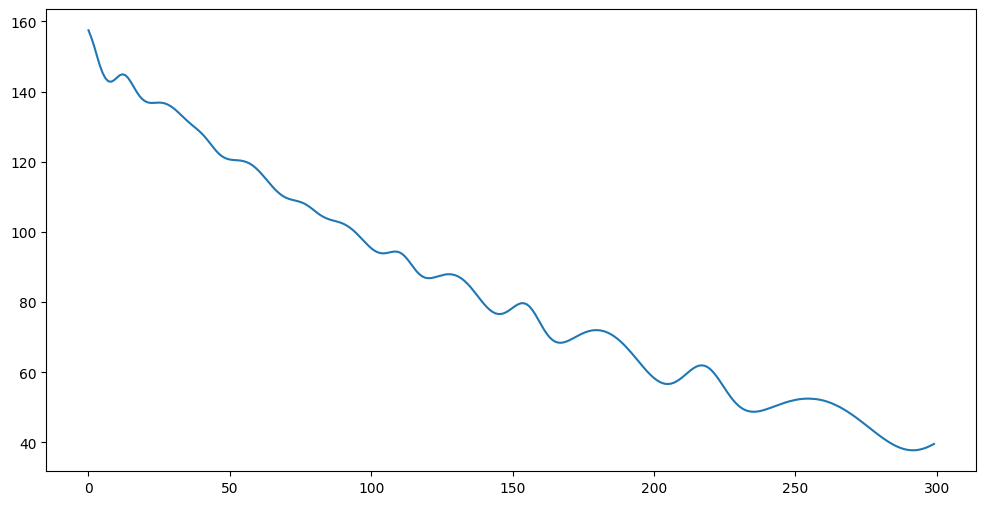

In [8]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300 #ORIGINALLY 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [9]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [10]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [11]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [12]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([581, 3, 13]) train_y: torch.Size([581, 1]) train_y_gan: torch.Size([581, 4, 1])
test_x: torch.Size([144, 3, 13]) test_y: torch.Size([144, 1]) test_y_gan: torch.Size([144, 4, 1])


In [13]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [25]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128 
learning_rate = 0.00016
num_epochs = 150 #ORIGINALLY 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(13).to(device) #13 was originally 17
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/150] LossD: 6.9343156814575195 LossG:3.6012296080589294
[2/150] LossD: 6.93176794052124 LossG:3.5564833283424377
[3/150] LossD: 6.933668613433838 LossG:3.5186105370521545
[4/150] LossD: 6.931912302970886 LossG:3.4988998770713806
[5/150] LossD: 6.931456208229065 LossG:3.482105314731598
[6/150] LossD: 6.931352257728577 LossG:3.4718395471572876
[7/150] LossD: 6.9312357902526855 LossG:3.466688871383667
[8/150] LossD: 6.9312310218811035 LossG:3.465088427066803
[9/150] LossD: 6.931076884269714 LossG:3.4652148485183716
[10/150] LossD: 6.931021332740784 LossG:3.4648178219795227
[11/150] LossD: 6.930952072143555 LossG:3.4646766781806946
[12/150] LossD: 6.930888414382935 LossG:3.4648985266685486
[13/150] LossD: 6.930820822715759 LossG:3.464895486831665
[14/150] LossD: 6.930831432342529 LossG:3.4650387167930603
[15/150] LossD: 6.930821657180786 LossG:3.4651681184768677
[16/150] LossD: 6.930830478668213 LossG:3.465184509754181
[17/150] LossD: 6.930928826332092 LossG:3.465608775615692
[18/150] L

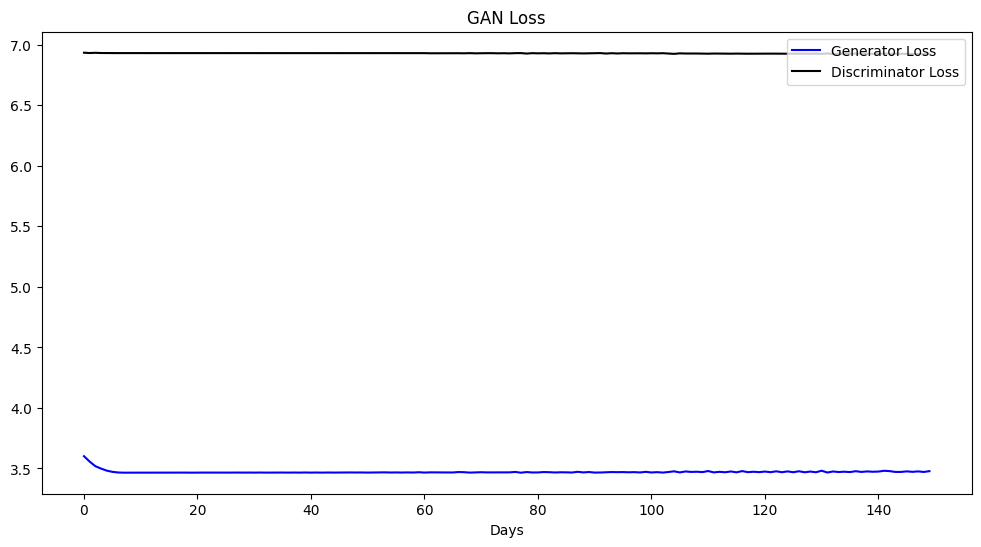

In [26]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [27]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())
print(y_train_pred)
y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

[[ 79.19305 ]
 [ 80.59135 ]
 [ 83.057396]
 [ 77.653275]
 [ 76.69634 ]
 [ 78.6892  ]
 [ 82.14294 ]
 [ 77.251045]
 [ 79.84414 ]
 [ 75.41007 ]
 [ 78.35655 ]
 [ 77.838455]
 [ 81.356064]
 [ 81.82624 ]
 [ 79.872375]
 [ 82.95497 ]
 [ 83.09728 ]
 [ 84.190384]
 [ 83.814995]
 [ 86.34013 ]
 [ 89.86017 ]
 [ 91.73409 ]
 [ 90.425964]
 [ 91.831856]
 [ 93.951324]
 [ 94.732254]
 [ 93.470764]
 [ 92.90609 ]
 [ 93.54534 ]
 [ 91.622246]
 [ 93.17539 ]
 [ 90.585304]
 [ 90.373726]
 [ 89.085175]
 [ 91.537094]
 [ 93.8741  ]
 [ 93.77656 ]
 [ 94.685776]
 [ 96.30121 ]
 [ 98.342896]
 [ 94.43307 ]
 [ 94.059265]
 [ 93.06699 ]
 [ 93.84798 ]
 [ 98.55993 ]
 [101.09958 ]
 [ 99.10428 ]
 [ 93.66314 ]
 [ 92.83468 ]
 [ 92.59593 ]
 [ 94.61223 ]
 [ 93.31804 ]
 [ 95.23011 ]
 [ 99.32153 ]
 [105.550644]
 [117.16717 ]
 [121.8952  ]
 [118.072685]
 [114.18836 ]
 [112.464836]
 [115.05524 ]
 [113.94993 ]
 [113.58729 ]
 [110.49346 ]
 [112.92698 ]
 [113.89089 ]
 [113.2917  ]
 [112.64548 ]
 [118.69959 ]
 [124.968956]
 [128.19371 ]
 [128.

Training dataset RMSE:4.724854380008663


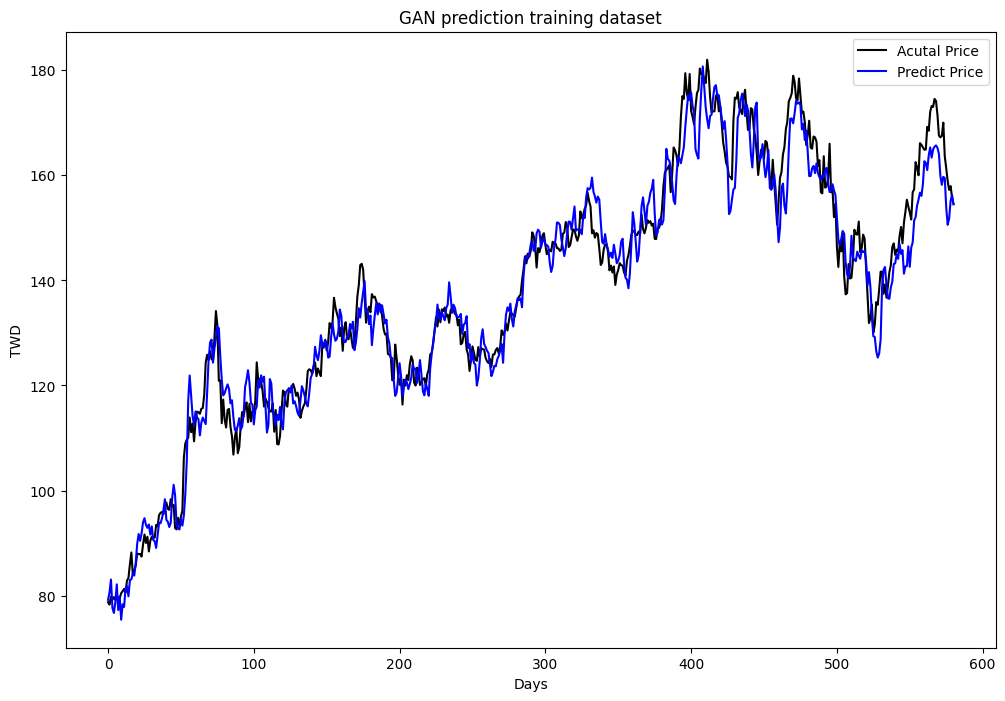

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:5.399698690331441


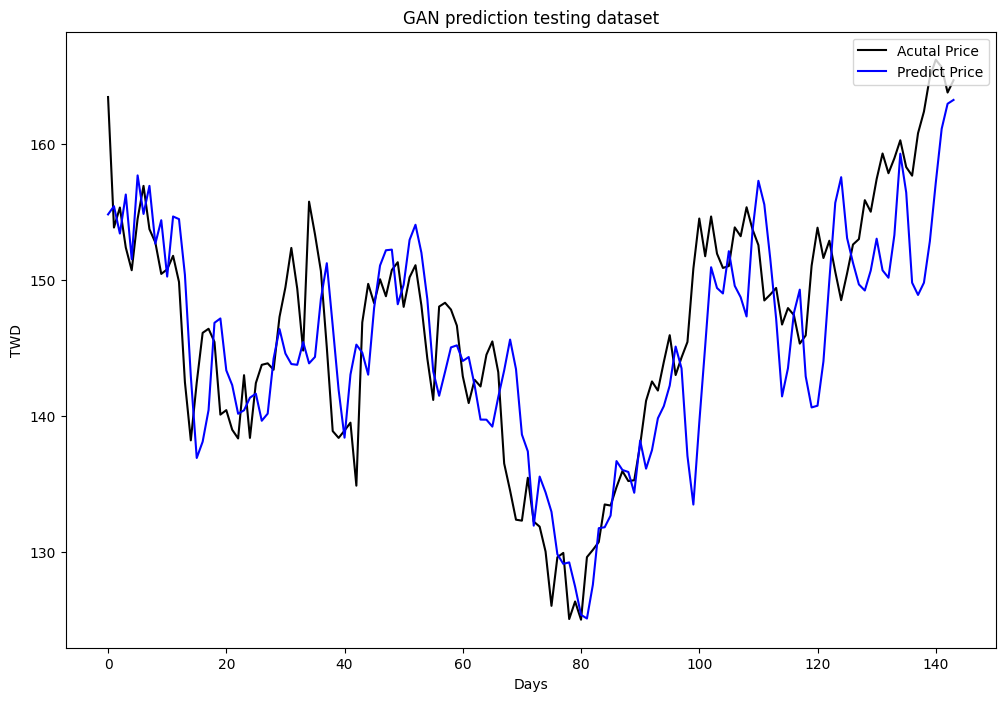

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')